# Breast Cancer Classification with Neural Networks

In this notebook, we build a neural network to classify breast tumors as **benign** or **malignant** using the [Breast Cancer Wisconsin Dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic).

The workflow includes:
1. Data loading and preprocessing
2. Model definition
3. Training loop
4. Evaluation (accuracy, loss curves, confusion matrix)
5. Logging and saving results

## Import the libraries
We start by importing the required Python libraries:  

- **pandas, numpy** → data handling and preprocessing  
- **scikit-learn** → dataset loading, train/test split, evaluation metrics  
- **matplotlib** → visualization of loss/accuracy curves and confusion matrix  
- **torch, torch.nn, torch.optim** → building and training the neural network 

In [1]:
import os

import pandas as pd 
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch.optim as optim

## Load the data  

We load the Breast Cancer dataset and prepare it for training:  
1. **Balance the dataset** → The dataset has more benign than malignant samples.
   To avoid bias, we select the same number of samples for each class.  
3. **Combine features and targets** → Features and labels are merged into a single DataFrame for easier manipulation.  
4. **Separate the two classes** → Split the dataset into *Benign (B)* and *Malignant (M)* subsets.  
5. **Select 200 samples per class** → We randomly choose an equal number of samples (200) from each class.  
6. **Recombine the dataset** → Merge the subsets back together to form a balanced dataset ready for preprocessing.  


In [2]:
breast_cancer_dataset = fetch_ucirepo(id=17)
X = breast_cancer_dataset.data.features
y = breast_cancer_dataset.data.targets

In [3]:
display(X.head())

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
display(y.tail())

,Diagnosis
564,M
565,M
566,M
567,M
568,B


In [5]:
display(y['Diagnosis'].value_counts())

Diagnosis
B    357
M    212
Name: count, dtype: int64

In [6]:
dataset = pd.concat([X, y], axis=1)

data_B = dataset[dataset['Diagnosis'] == 'B']
data_M = dataset[dataset['Diagnosis'] == 'M']

sample_number = min(len(data_B), len(data_M))
data_B = data_B.sample(n=sample_number, random_state=12)
data_M = data_M.sample(n=sample_number, random_state=12)

balanced_dataset = pd.concat([data_B, data_M])

In [7]:
display(balanced_dataset['Diagnosis'].value_counts())

Diagnosis
B    212
M    212
Name: count, dtype: int64

## Preprocessing
1. **Separate the features and the targets** → Extract the feature matrix `X` and the target vector `y`. The labels (*Benign* and *Malignant*) are mapped to numerical values (0 and 1).  
2. **Split the data into train and test sets**
3. **Standardize the data** → Features are standardized using `StandardScaler` so that they have zero mean and unit variance.  
4. **Transform the data into PyTorch tensors** → Both features and labels are converted into tensors, the format required by PyTorch models.
5. **Create DataLoaders for training and test sets** → The tensors are wrapped into `DataLoader` objects.  
   - The training DataLoader uses **shuffling** to ensure randomness at each epoch.  
   - The test DataLoader does not shuffle, so results remain consistent.  

In [8]:
X = balanced_dataset.drop(['Diagnosis'], axis=1)
y = balanced_dataset['Diagnosis']

y = y.map({'B':0, 'M':1})

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

In [10]:
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

In [11]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [12]:
training_dataset = TensorDataset(X_train, y_train)
testing_dataset = TensorDataset(X_test, y_test)

batch_size = 12
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

## Build, train and test the Neural Network

### Build the Neural Network  
We define a simple feedforward neural network using **PyTorch**.  
- The input layer size matches the number of features.  
- A hidden layer with ReLU activation introduces non-linearity.  
- The output layer provides two logits (Benign vs. Malignant).  
- We use **CrossEntropyLoss** as the loss function and **Adam** as the optimizer.  

### Train and Test  
The model is trained over several epochs.  
- For each epoch, the training loop computes the loss, updates the model weights and tracks accuracy.  
- After training, the model is evaluated on the test set to measure generalization performance.  
- Both training and testing losses/accuracies are stored for visualization.  

### Confusion Matrix (Last Epoch)  
After the final epoch, we generate a **confusion matrix** on the test set.  
This provides a clear visualization of true positives, false positives, true negatives and false negatives, helping to evaluate how well the model distinguishes between the two classes.  

In [13]:
class Classification(nn.Module):
    def __init__(self, INPUT_NB, HIDDEN_NB, OUTPUT_NB):
        super().__init__()
        self.layer1 = nn.Linear(INPUT_NB, HIDDEN_NB)
        self.layer2 = nn.Linear(HIDDEN_NB, OUTPUT_NB)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        return x

In [14]:
INPUT_NB = X.shape[1]
HIDDEN_NB = 32
OUTPUT_NB = len(y.unique())
learning_rate = 0.001

model = Classification(INPUT_NB, HIDDEN_NB, OUTPUT_NB)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
epochs = 30
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == y_batch).sum().item()

    average_train_accuracy = total_train_correct / len(training_dataset)
    average_train_loss = total_train_loss / len(train_loader)

    train_accuracy.append(average_train_accuracy)
    train_loss.append(average_train_loss)

    
    model.eval()
    total_test_loss = 0.0
    total_test_correct = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_test_loss += loss.item()
    
            _, predicted = torch.max(outputs, 1)
            total_test_correct += (predicted == y_batch).sum().item()
    
    average_test_accuracy = total_test_correct / len(testing_dataset)
    average_test_loss = total_test_loss / len(test_loader)

    test_accuracy.append(average_test_accuracy)
    test_loss.append(average_test_loss)

In [16]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.tolist())
        all_labels.extend(y_batch.tolist())

## Plot the curves

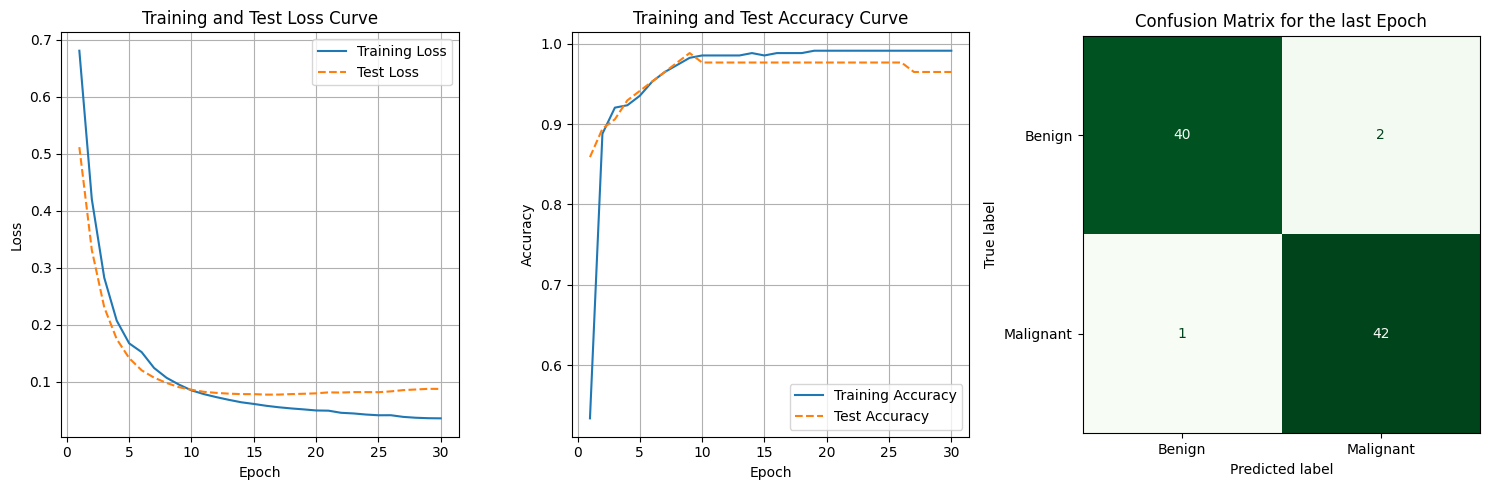

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(range(1, epochs + 1), train_loss, label='Training Loss')
axs[0].plot(range(1, epochs + 1), test_loss, label='Test Loss', linestyle='--')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Test Loss Curve')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(1, epochs + 1), train_accuracy, label='Training Accuracy')
axs[1].plot(range(1, epochs + 1), test_accuracy, label='Test Accuracy', linestyle='--')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Test Accuracy Curve')
axs[1].legend()
axs[1].grid(True)


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap="Greens", ax=axs[2], colorbar=False)
axs[2].set_title("Confusion Matrix for the last Epoch")

plt.tight_layout()
plt.show()

## Save the results

After training and evaluation, we save the hyperparameters and performance metrics of each run to a CSV file.  

This includes:  
- Model configuration (hidden units, learning rate, batch size, epochs)  
- Training metrics (best and final training accuracy/loss)  
- Test metrics (best and final test accuracy/loss)  

In [18]:
new_data = {
    "Hidden Units": HIDDEN_NB,
    "Learning Rate": learning_rate,
    "Batch Size": batch_size,
    "Epochs": epochs,
    "Best Train Accuracy": max(train_accuracy)*100,
    "Final Train Accuracy": train_accuracy[-1]*100,
    "Best Test Accuracy": max(test_accuracy)*100,
    "Final Test Accuracy": test_accuracy[-1]*100,
    "Best Train Loss": min(train_loss),
    "Final Train Loss": train_loss[-1],
    "Best Test Loss": min(test_loss),
    "Final Test Loss": test_loss[-1],
}

df_new = pd.DataFrame([new_data])

if os.path.exists("results.csv"):
    df_existing = pd.read_csv("results.csv")
    df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    df_combined.to_csv("results.csv", index=False)
else:
    df_new.to_csv("results.csv", index=False)

df = pd.read_csv("results.csv")
display(df)

,Hidden Units,Learning Rate,Batch Size,Epochs,Best Train Accuracy,Final Train Accuracy,Best Test Accuracy,Final Test Accuracy,Best Train Loss,Final Train Loss,Best Test Loss,Final Test Loss
0,64,0.001,20,20,99.062500,99.062500,97.500000,97.500000,0.051408,0.051408,0.093076,0.095196
1,64,0.001,12,20,99.062500,99.062500,97.500000,97.500000,0.037538,0.037538,0.091472,0.097260
2,64,0.001,12,30,99.375000,99.375000,97.500000,97.500000,0.025922,0.025922,0.088300,0.101191
3,32,0.001,12,30,99.115044,99.115044,98.823529,96.470588,0.032061,0.032061,0.076037,0.088342
4,32,0.001,12,30,99.115044,99.115044,98.823529,96.470588,0.035570,0.035570,0.077212,0.087197
